# Import pustaka yang digunakan

In [1]:
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, roc_auc_score
from cvxopt import matrix, spmatrix, solvers
import numba
from joblib import dump, load
from abc import ABC, abstractmethod

# Preprocessing

In [4]:
dataset_path = "ISIC_2019_Training_Input"

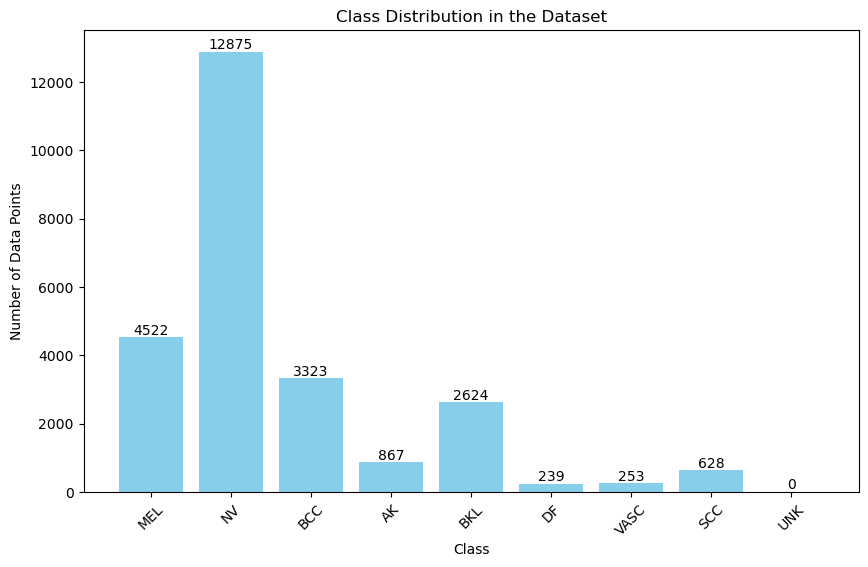

In [5]:
# Load CSV ground truth
csv_path = "ISIC_2019_Training_GroundTruth.csv"
df = pd.read_csv(csv_path)

# Hitung jumlah tiap kelas
class_counts = df.iloc[:, 1:].sum()

# Plot distribusi kelas orisinal
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=45)
plt.show()

In [4]:
class MetadataHandler:
    def __init__(self, csv_path, output_path="relabeled_metadata_svm.csv"):
        self.csv_path = csv_path
        self.output_path = output_path
        self.metadata_df = self.load_and_relabel_metadata()

    def load_and_relabel_metadata(self):
        df = pd.read_csv(self.csv_path)
        melanoma = ['MEL']
        non_melanoma = ['NV', 'AK', 'BKL', 'DF', 'VASC', 'BCC', 'SCC']
        if 'UNK' in df.columns:
            df = df.drop(['UNK'], axis=1)
        df['class'] = 2 * (df[melanoma].sum(axis=1) > 0).astype(int) - 1
        df = df.drop(melanoma + non_melanoma, axis=1)
        df.to_csv(self.output_path, index=False)
        print(f"Metadata yang telah di-relabel disimpan di: {self.output_path}")
        return df
    
    @staticmethod
    def save_to_csv(class_encodings, image_names, output_dir, prefix):
        # Buat direktori jika tidak ada
        os.makedirs(output_dir, exist_ok=True)
        
        # Buat DataFrame dengan nama gambar dan pengkodean kelas yang sesuai
        df = pd.DataFrame({
            'image_name': image_names,
            'class': class_encodings
        })
        
        # Validasi data
        melanoma_count = sum(df['class'] == 1)
        non_melanoma_count = sum(df['class'] == -1)
        total_count = len(df)
        
        print("\nStatistik Dataset:")
        print(f"Total gambar: {total_count}")
        print(f"Gambar Melanoma: {melanoma_count}")
        print(f"Gambar Non-melanoma: {non_melanoma_count}")
        print(f"Distribusi kelas: {df['class'].value_counts()}")
        
        # Simpan DataFrame ke file CSV
        csv_path = os.path.join(output_dir, f"{prefix}_ground_truth.csv")
        df.to_csv(csv_path, index=False)
        print(f"\nGround truth disimpan di: {csv_path}")

    @staticmethod
    def plot_class_distribution(metadata_df):
        class_counts = metadata_df['class'].value_counts().sort_index()
        colors = ['#ff7f0e', '#1f77b4']
        plt.figure(figsize=(8, 6))
        bars = plt.bar(['Non-Melanoma (-1)', 'Melanoma (1)'], class_counts.values, color=colors)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution for SVM')
        plt.show()

In [5]:
class ImageProcessor:
    def __init__(self, target_size=224):
        self.target_size = target_size

    def extract_roi(self, img_rgb):
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [largest_contour], 0, 255, -1)
        roi = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return roi[y:y+h, x:x+w]

    def resize_and_pad(self, image):
        old_size = image.shape[:2]
        ratio = float(self.target_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        resized = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = self.target_size - new_size[1]
        delta_h = self.target_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        return cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    def apply_augmentations(self, image):
        augmented_images = [image]
        augmented_names = ['original']
        rotations = [(cv2.ROTATE_90_CLOCKWISE, 'rotated_90'), (cv2.ROTATE_90_COUNTERCLOCKWISE, 'rotated_270')]
        flips = [(0, 'vertical_flip'), (1, 'mirrored')]
        
        for rotation, name in rotations:
            augmented_images.append(cv2.rotate(image, rotation))
            augmented_names.append(name)
        for flip, name in flips:
            augmented_images.append(cv2.flip(image, flip))
            augmented_names.append(name)
        return augmented_images, augmented_names
    
    def normalize(self, image):
        return preprocess_input(image.astype(np.float32))

In [6]:
class DatasetSplitter:
    def __init__(self, metadata_df):
        self.metadata_df = metadata_df

    def split(self, test_size=0.2, stratify_column='class', random_state=42):
        train_metadata_df, test_metadata_df = train_test_split(
            self.metadata_df,
            test_size=test_size,
            stratify=self.metadata_df[stratify_column],
            random_state=random_state
        )
        return train_metadata_df, test_metadata_df

In [7]:
class DatasetProcessor:
    def __init__(self, image_processor, dataset_path, output_dir, apply_augmentation=True, is_training=True):
        """
        Inisialisasi DatasetProcessor.
        
        Args:
            image_processor (ImageProcessor): Instance dari ImageProcessor untuk operasi gambar
            dataset_path (str): Path ke dataset sumber
            output_dir (str): Path untuk menyimpan gambar yang telah diproses
            apply_augmentation (bool): Apakah menerapkan augmentasi
            is_training (bool): Apakah memproses data pelatihan atau validasi
        """
        self.image_processor = image_processor
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        self.apply_augmentation = apply_augmentation
        self.is_training = is_training
        
    def process_single_image(self, image_path, apply_augmentation=True):
        """Proses satu gambar dengan pilihan augmentasi."""
        img = cv2.imread(image_path)
        if img is None:
            return [], []
            
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        processed_images = []
        image_names = []
        
        if apply_augmentation:
            augmented_images, aug_names = self.image_processor.apply_augmentations(img_rgb)
        else:
            augmented_images = [img_rgb]
            aug_names = ['original']
        
        for aug_img, aug_name in zip(augmented_images, aug_names):
            roi = self.image_processor.extract_roi(aug_img)
            processed = self.image_processor.resize_and_pad(roi)
            processed = self.image_processor.normalize(processed)
            
            processed_images.append(processed)
            image_names.append(aug_name)
        
        return processed_images, image_names
    
    def process_dataset(self, metadata_df):
        """
        Proses seluruh dataset menggunakan metadata.
        
        Args:
            metadata_df (pd.DataFrame): DataFrame yang berisi metadata gambar dengan kolom 'image' dan 'class'
        
        Returns:
            tuple: Daftar enkoding kelas dan nama gambar yang telah diproses
        """
        os.makedirs(self.output_dir, exist_ok=True)
        
        all_class_encodings = []
        all_image_names = []
        
        non_melanoma_count = sum(metadata_df['class'] == -1)
        melanoma_count = sum(metadata_df['class'] == 1)
        
        if self.is_training and self.apply_augmentation:
            target_melanoma_count = non_melanoma_count
            melanoma_images_needed = target_melanoma_count - melanoma_count
        else:
            melanoma_images_needed = 0
        
        print("Memproses gambar asli...")
        for index, row in metadata_df.iterrows():
            image_name = row['image']
            class_encoding = row['class']
            
            image_path = os.path.join(self.dataset_path, image_name + '.jpg')
            if not os.path.exists(image_path):
                print(f"Peringatan: Gambar tidak ditemukan di {image_path}")
                continue
            
            processed_images, image_names = self.process_single_image(
                image_path, 
                apply_augmentation=False
            )
            
            base_name = os.path.splitext(image_name)[0]
            for proc_img, img_name in zip(processed_images, image_names):
                save_path = os.path.join(self.output_dir, f"{base_name}_{img_name}.npy")
                np.save(save_path, proc_img)
                all_image_names.append(f"{base_name}_{img_name}.npy")
                all_class_encodings.append(class_encoding)
        
        if self.is_training and self.apply_augmentation and melanoma_images_needed > 0:
            print("\nMenerapkan augmentasi ke gambar melanoma...")
            melanoma_images = metadata_df[metadata_df['class'] == 1]
            
            additional_melanoma_count = 0
            for _, row in melanoma_images.iterrows():
                if additional_melanoma_count >= melanoma_images_needed:
                    break
                    
                image_name = row['image']
                image_path = os.path.join(self.dataset_path, image_name + '.jpg')
                if not os.path.exists(image_path):
                    continue
                
                processed_images, image_names = self.process_single_image(
                    image_path, 
                    apply_augmentation=True
                )
                
                base_name = os.path.splitext(image_name)[0]
                for proc_img, img_name in zip(processed_images[1:], image_names[1:]):
                    if additional_melanoma_count >= melanoma_images_needed:
                        break
                        
                    save_path = os.path.join(self.output_dir, f"{base_name}_{img_name}.npy")
                    np.save(save_path, proc_img)
                    all_image_names.append(f"{base_name}_{img_name}.npy")
                    all_class_encodings.append(1)
                    additional_melanoma_count += 1
        
        if self.is_training and self.apply_augmentation:
            final_melanoma_count = melanoma_count + additional_melanoma_count
            print(f"\nJumlah melanoma asli: {melanoma_count}")
            print(f"Augmentasi melanoma tambahan: {additional_melanoma_count}")
            print(f"Total melanoma: {final_melanoma_count}")
            print(f"Jumlah non-melanoma: {non_melanoma_count}")
            print(f"Total gambar yang diproses: {len(all_class_encodings)}")
            print(f"Perbedaan keseimbangan kelas: {final_melanoma_count - non_melanoma_count}")
        
        return all_class_encodings, all_image_names

In [10]:
# Load and relabel metadata
metadata_handler = MetadataHandler(csv_path=csv_path)

Metadata yang telah di-relabel disimpan di: relabeled_metadata_svm.csv


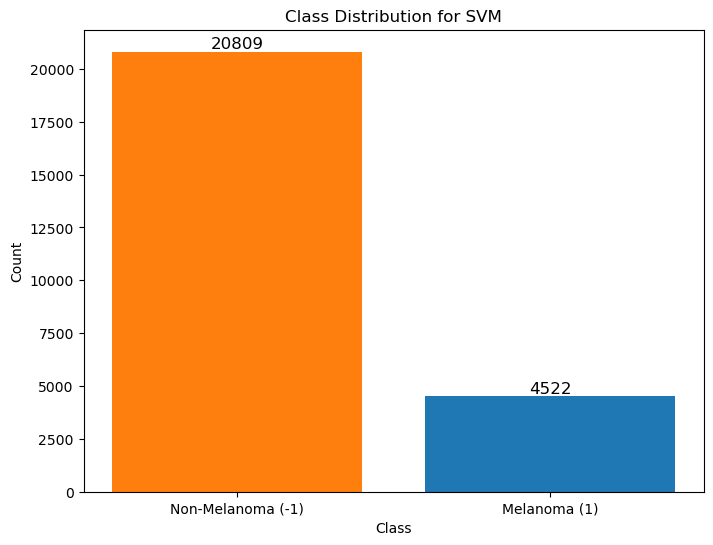

In [11]:
# Load dan relabel ground truth
relabeled_df = metadata_handler.metadata_df

# Plot distribusi kelas
MetadataHandler.plot_class_distribution(relabeled_df)

In [12]:
# Print baris-baris awal untuk verifikasi relabeling
print(relabeled_df.head())

# Print nama kolumn untuk verifikasi
print("\nColumns in relabeled metadata:")
print(sum(relabeled_df['class'] == 1))

          image  class
0  ISIC_0000000     -1
1  ISIC_0000001     -1
2  ISIC_0000002      1
3  ISIC_0000003     -1
4  ISIC_0000004      1

Columns in relabeled metadata:
4522


In [13]:
# Split dataset
splitter = DatasetSplitter(relabeled_df)
train_metadata_df, test_metadata_df = splitter.split(test_size=0.2, stratify_column='class', random_state=42)

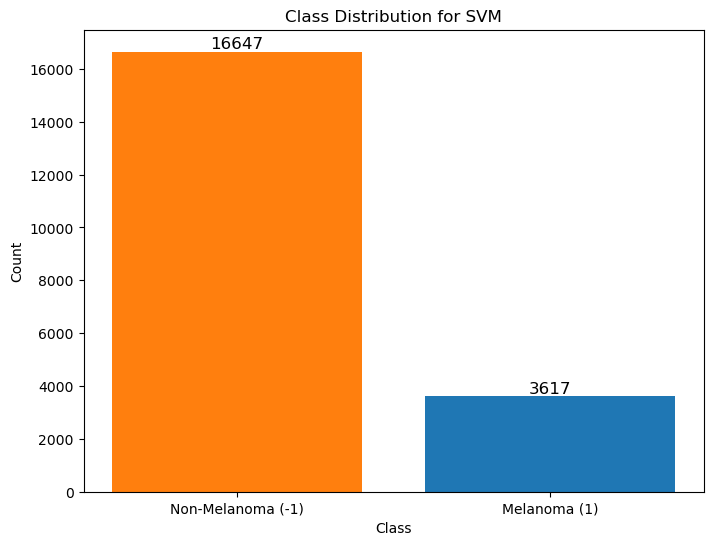

In [14]:
# Plot distribusi kelas training
MetadataHandler.plot_class_distribution(train_metadata_df)

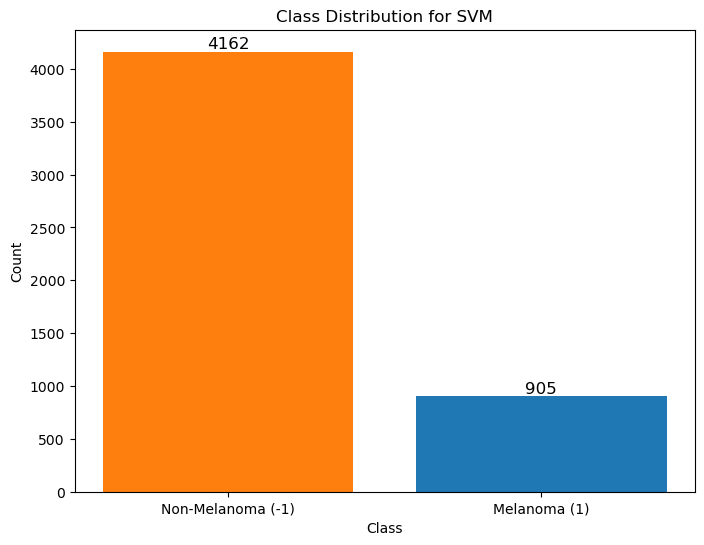

In [15]:
# Plot distribusi kelas testing
MetadataHandler.plot_class_distribution(test_metadata_df)

In [16]:
image_processor = ImageProcessor(target_size=224)

In [17]:
# Process train dataset
train_processor = DatasetProcessor(
    image_processor=image_processor,
    dataset_path='ISIC_2019_Training_Input',
    output_dir='preprocessed/train',
    apply_augmentation=True,
    is_training=True
)
train_encodings, train_images = train_processor.process_dataset(train_metadata_df)

# Process test dataset
test_processor = DatasetProcessor(
    image_processor=image_processor,
    dataset_path='ISIC_2019_Training_Input',
    output_dir='preprocessed/test',
    apply_augmentation=False,
    is_training=False
)
test_encodings, test_images = test_processor.process_dataset(test_metadata_df)

Processing original images...

Applying augmentation to melanoma images...

Original melanoma count: 3617
Additional augmented melanoma: 13030
Total melanoma: 16647
Non-melanoma count: 16647
Total processed images: 33294
Class balance difference: 0
Processing original images...


In [4]:
train_output_dir = "preprocessed/train/ground_truth"
test_output_dir = "preprocessed/test/ground_truth"

In [19]:
MetadataHandler.save_to_csv(
    class_encodings=train_encodings,
    image_names=train_images,
    output_dir=train_output_dir,
    prefix="train"
)

MetadataHandler.save_to_csv(
    class_encodings=test_encodings,
    image_names=test_images,
    output_dir=test_output_dir,
    prefix="test"
)


Statistik Dataset:
Total gambar: 33294
Gambar Melanoma: 16647
Gambar Non-melanoma: 16647
Distribusi kelas: class
-1    16647
 1    16647
Name: count, dtype: int64

Ground truth disimpan di: preprocessed/train/ground_truth\train_ground_truth.csv

Statistik Dataset:
Total gambar: 5067
Gambar Melanoma: 905
Gambar Non-melanoma: 4162
Distribusi kelas: class
-1    4162
 1     905
Name: count, dtype: int64

Ground truth disimpan di: preprocessed/test/ground_truth\test_ground_truth.csv


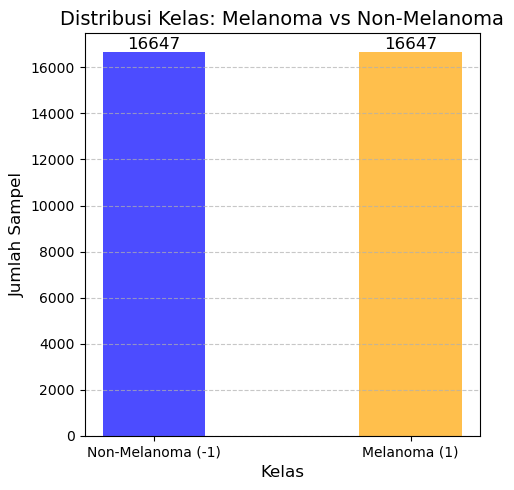

In [20]:
# Muat dataset
data = pd.read_csv('preprocessed/train/ground_truth/train_ground_truth.csv')

# Menghitung jumlah kemunculan setiap kelas
class_counts = data['class'].value_counts()

# Buat histogram
plt.figure(figsize=(5, 5))
bars = plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'], alpha=0.7)

# Atur judul dan label
plt.title('Distribusi Kelas: Melanoma vs Non-Melanoma', fontsize=14)
plt.xlabel('Kelas', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.xticks(ticks=[-1, 1], labels=['Non-Melanoma (-1)', 'Melanoma (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan jumlah tepat di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

# Tampilkan plot
plt.tight_layout()
plt.show()

# Feature Extraction with MobileNetV2

In [5]:
class FeatureExtractor:
    def __init__(self, input_shape=(224, 224, 3)):
        self.base_model = self.setup_model(input_shape)

    def setup_model(self, input_shape):
        base_model = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
        base_model.trainable = False
        return base_model

    def get_features(self, image_path, features_dir):
        base_filename = os.path.splitext(os.path.basename(image_path))[0]
        features_path = os.path.join(features_dir, base_filename + '.npy')
        
        if os.path.exists(features_path):
            features = np.load(features_path)
        else:
            img_array = np.load(image_path)
            if img_array.shape != (224, 224, 3):
                raise ValueError(f"Bentuk gambar yang dimuat {img_array.shape} tidak sesuai dengan bentuk input yang diharapkan (224, 224, 3)")
            img_array = np.expand_dims(img_array, axis=0)
            features = self.base_model.predict(img_array).flatten()
            np.save(features_path, features)
        
        return features

    def extract_features(self, df, preprocessed_dir, features_dir):
        os.makedirs(features_dir, exist_ok=True)
        features = []
        for _, row in df.iterrows():
            image_path = os.path.join(preprocessed_dir, row['image_name'])
            features.append(self.get_features(image_path, features_dir))
        return np.array(features)

    def process_dataset(self, ground_truth_path, preprocessed_dir, features_dir):
        df = pd.read_csv(ground_truth_path)
        features = self.extract_features(df, preprocessed_dir, features_dir)
        return features, df['class'].values

In [6]:
extractor = FeatureExtractor()

# Training data
train_features, train_labels = extractor.process_dataset(
    "preprocessed/train/ground_truth/train_ground_truth.csv",
    "preprocessed/train",
    "preprocessed/train/extracted_features_gpu"
)
print(f"Training features shape: {train_features.shape}")
print(f"Training labels shape: {train_labels.shape}")

# Testing data
test_features, test_labels = extractor.process_dataset(
    "preprocessed/test/ground_truth/test_ground_truth.csv",
    "preprocessed/test",
    "preprocessed/test/extracted_features_gpu"
)
print(f"Testing features shape: {test_features.shape}")
print(f"Testing labels shape: {test_labels.shape}")

Training features shape: (33294, 1280)
Training labels shape: (33294,)
Testing features shape: (5067, 1280)
Testing labels shape: (5067,)


# Support Vector Machine

In [7]:
class BaseSVM(ABC):
    def __init__(self, C=1.0, tolerance=1e-5):
        self.C = C
        self.tolerance = tolerance
        self.a = None
        self.sv = None
        self.sv_y = None
        self.b = None

    @abstractmethod
    def kernel(self, X1, X2):
        """Metode abstrak untuk komputasi kernel."""
        pass

    def fit(self, X, y):
        n_samples = X.shape[0]
        K = self.kernel(X, X)

        # Prepare QP problem
        P = matrix(np.outer(y, y) * K)
        q = matrix(-1.0 * np.ones(n_samples))
        A = matrix(y.astype(float), (1, n_samples))
        b = matrix(0.0)

        G = spmatrix(
            [-1.0] * n_samples + [1.0] * n_samples,
            list(range(2 * n_samples)),
            list(range(n_samples)) * 2
        )
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

        # Solve QP
        solvers.options['show_progress'] = True
        solution = solvers.qp(P, q, G, h, A, b)

        # Extract support vectors
        a = np.ravel(solution['x'])
        sv_mask = a > self.tolerance
        self.a = a[sv_mask]
        self.sv = X[sv_mask]
        self.sv_y = y[sv_mask]

        # Calculate intercept
        K_sv = self.kernel(self.sv, self.sv)
        self.b = np.mean(
            self.sv_y - np.sum(self.a * self.sv_y * K_sv, axis=1)
        )

    def decision_function(self, X):
        """Hitung decision function."""
        K = self.kernel(X, self.sv)
        return np.dot(K, self.a * self.sv_y) + self.b

    def predict(self, X):
        """Lakukan prediksi menggunakan decision function."""
        decision_values = self.decision_function(X)
        return np.sign(decision_values)

In [8]:
class SVM(BaseSVM):
    def kernel(self, X1, X2):
        """Kernel linier."""
        return np.dot(X1, X2.T)
    
    def calculate_weights(self): 
        """Hitung vektor bobot.""" 
        self.w = np.sum(self.a[:, None] * self.sv_y[:, None] * self.sv, axis=0) 
        
    def fit(self, X, y): 
        super().fit(X, y) 
        self.calculate_weights()

In [9]:
class SVM_RBF(BaseSVM):
    def __init__(self, C=1.0, gamma=0.1, chunk_size=1000, tolerance=1e-5):
        super().__init__(C, tolerance)
        self.gamma = gamma
        self.chunk_size = chunk_size

    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def _rbf_kernel_numba(X1, X2, gamma):
        n_samples1, n_features = X1.shape
        n_samples2 = X2.shape[0]
        K = np.zeros((n_samples1, n_samples2))

        for i in numba.prange(n_samples1):
            for j in range(n_samples2):
                dist = 0.0
                for k in range(n_features):
                    diff = X1[i, k] - X2[j, k]
                    dist += diff * diff
                K[i, j] = np.exp(-gamma * dist)
        return K

    def kernel(self, X1, X2):
        """RBF kernel dengan chunking."""
        return self._rbf_kernel_numba(X1, X2, self.gamma)

In [ ]:
class HyperparameterTuner:
    def __init__(self, model_class, params_grid):
        self.model_class = model_class
        self.params_grid = params_grid
        self.results = {}

    def tune(self, train_features, train_labels, test_features, test_labels, model_save_dir):
        os.makedirs(model_save_dir, exist_ok=True)  # Pastikan direktori ada
        for params in self.params_grid:
            C_value = params.get('C')
            gamma_value = params.get('gamma', 'None')
            print(f"Tuning dengan parameter: C = {C_value}, gamma = {gamma_value}")
            
            # Logika penamaan model yang diperbarui
            if 'gamma' in params:
                # Untuk SVM RBF
                model_name = f"svm_rbf_model_C_{C_value}_gamma_{gamma_value}.joblib"
            else:
                # Untuk SVM Linear
                model_name = f"svm_model_C_{C_value}.joblib"
                
            model_path = os.path.join(model_save_dir, model_name)

            # Cek jika model sudah disimpan
            if os.path.exists(model_path):
                print(f"Model sudah disimpan di {model_path}. Melewatkan pelatihan.")
                model = load(model_path)
            else:
                # Inisialisasi dan latih model
                model = self.model_class(**params)
                model.fit(train_features, train_labels)
                # Simpan model
                dump(model, model_path)
                print(f"Model disimpan di {model_path}.")

            # Evaluasi pada set tes
            y_pred = model.predict(test_features)

            # Hitung matriks kebingungan dan recall
            cm = confusion_matrix(test_labels, y_pred)
            recall = recall_score(test_labels, y_pred)
            precision = precision_score()

            # Hitung Precision-Recall Curve dan Average Precision (AP)
            y_pred_prob = model.decision_function(test_features)  # Mendapatkan skor dari decision function

            # Simpan hasil
            self.results[frozenset(params.items())] = {
                'confusion_matrix': cm,
                'recall': recall,
                'precision': precision,
                'decision_function': y_pred_prob,
                'test_labels': test_labels
            }

            print(f"Matriks Kebingungan:\n{cm}")
            print(f"Recall: {recall:.6f}")

In [11]:
class SVMPipeline: 
    def __init__(self, model_class, model_save_dir, tuner, X_train, y_train, X_test, y_test): 
        self.model_class = model_class  
        self.model_save_dir = model_save_dir
        self.tuner = tuner
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    def run(self): 
        os.makedirs(self.model_save_dir, exist_ok=True)
        self.tuner.tune(self.X_train, self.y_train, self.X_test, self.y_test, self.model_save_dir)

In [ ]:
# Definisikan parameter grid untuk SVM RBF
rbf_params_grid = [
    {"C": C, "gamma": gamma} for C in [0.001, 0.01, 0.1, 1, 10] for gamma in [0.0001, 0.001, 0.01, 0.1, 1]
]

# Definisikan parameter grid untuk SVM linear
linear_params_grid = [
    {"C": C} for C in [0.0001, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.005, 0.01, 0.1, 1, 10]
]

# Inisialisasi tuner dan pipeline untuk SVM RBF, menyimpan model di 'models_rbf'
rbf_tuner = HyperparameterTuner(SVM_RBF, rbf_params_grid)
rbf_pipeline = SVMPipeline(SVM_RBF, 'models_rbf', rbf_tuner, train_features, train_labels, test_features, test_labels)

# Inisialisasi tuner dan pipeline untuk SVM linear, menyimpan model di 'models_linear'
linear_tuner = HyperparameterTuner(SVM, linear_params_grid)
linear_pipeline = SVMPipeline(SVM, 'models_linear', linear_tuner, train_features, train_labels, test_features, test_labels)

# Jalankan pipeline RBF
print("Menjalankan pipeline SVM RBF:")
rbf_pipeline.run()

# Jalankan pipeline linear
print("\nMenjalankan pipeline SVM Linear:")
linear_pipeline.run()

Menjalankan pipeline SVM RBF:
Tuning dengan parameter: C = 0.001, gamma = 0.0001
Model sudah disimpan di models_rbf\svm_rbf_model_C_0.001_gamma_0.0001.joblib. Melewatkan pelatihan.
Matriks Kebingungan:
[[2840 1322]
 [ 402  503]]
Recall: 0.555801
Tuning dengan parameter: C = 0.001, gamma = 0.001
Model sudah disimpan di models_rbf\svm_rbf_model_C_0.001_gamma_0.001.joblib. Melewatkan pelatihan.
Matriks Kebingungan:
[[2791 1371]
 [ 367  538]]
Recall: 0.594475
Tuning dengan parameter: C = 0.001, gamma = 0.01
Model sudah disimpan di models_rbf\svm_rbf_model_C_0.001_gamma_0.01.joblib. Melewatkan pelatihan.
Matriks Kebingungan:
[[2810 1352]
 [ 273  632]]
Recall: 0.698343
Tuning dengan parameter: C = 0.001, gamma = 0.1
Model sudah disimpan di models_rbf\svm_rbf_model_C_0.001_gamma_0.1.joblib. Melewatkan pelatihan.
Matriks Kebingungan:
[[ 338 3824]
 [  17  888]]
Recall: 0.981215
Tuning dengan parameter: C = 0.001, gamma = 1
Model sudah disimpan di models_rbf\svm_rbf_model_C_0.001_gamma_1.joblib.

# Visualization

In [33]:
class ModelEvaluationVisualizer:
    def __init__(self, results, kernel_name):
        """
        Inisialisasi visualizer dengan data evaluasi model.

        Parameter:
            results (dict): Kamus hasil evaluasi dengan parameter dan metrik.
        """
        self.results = results
        self.kernel_name = kernel_name

    def plot_confusion_matrices(self, max_plots=None, save_dir="confusion_matrices"):
        """
        Plot dan simpan matriks kebingungan dengan format nama file sesuai kernel.

        Parameter:
            max_plots (int): Maksimal jumlah plot yang akan dibuat (opsional).
            save_dir (str): Direktori tempat menyimpan plot.
        """
        os.makedirs(save_dir, exist_ok=True)  # Membuat folder jika belum ada
        count = 0  # Counter untuk jumlah plot yang dibuat
        kernel_prefix = self.kernel_name or "unknown"  # Gunakan kernel_name jika disediakan

        for params, metrics in self.results.items():
            if max_plots and count >= max_plots:
                break

            cm = metrics.get('confusion_matrix')
            if cm is None:
                print(f"Peringatan: 'confusion_matrix' tidak ada untuk parameter: {params}")
                continue

            # Ambil parameter model
            params_dict = dict(params)
            C = params_dict.get('C', 'N/A')
            gamma = params_dict.get('gamma', 'N/A')

            # Plot matriks kebingungan
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.title(f"Matriks Kebingungan untuk C = {C}, gamma = {gamma}")
            plt.xlabel('Label Prediksi')
            plt.ylabel('Label Sebenarnya')
            plt.tight_layout()

            # Simpan plot dengan nama file
            count += 1
            filename = f"{kernel_prefix}_{count}.png"
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath, dpi=300)
            print(f"Saved confusion matrix plot: {filepath}")
            plt.close()  # Menutup plot untuk menghemat memori


    def plot_recall_scores(self):
        """Plot skor recall untuk berbagai parameter."""
        linear_data = []
        rbf_data = []

        # Kelompokkan data berdasarkan kernel linear atau RBF
        for params, metrics in self.results.items():
            params_dict = dict(params)
            C = params_dict.get('C')
            gamma = params_dict.get('gamma')
            recall = metrics.get('recall', 0)

            if gamma is None or gamma == 'None':  # Kernel linear
                linear_data.append((C, recall))
            else:  # Kernel RBF
                rbf_data.append((C, gamma, recall))

        # Plot untuk SVM linear
        if linear_data:
            linear_data = sorted(linear_data, key=lambda x: x[0])
            C_values, recall_scores = zip(*linear_data)

            plt.figure(figsize=(10, 6))
            sns.barplot(x=C_values, y=recall_scores, palette="viridis")
            for index, value in enumerate(recall_scores):
                offset = 0.02 if value < 0.9 else -0.05
                plt.text(index, value + offset, f'{value:.4f}', ha='center', va='bottom' if offset > 0 else 'top')
            plt.title('Skor Recall untuk SVM Linear')
            plt.xlabel('Nilai C')
            plt.ylabel('Recall')
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.savefig("linear_svm_recall.png", bbox_inches='tight', dpi=300)
            plt.show()

        # Plot untuk SVM RBF
        if rbf_data:
            unique_C = sorted(set(x[0] for x in rbf_data))

            for C in unique_C:
                plt.figure(figsize=(10, 6))
                C_data = [(g, r) for c, g, r in rbf_data if c == C]
                gamma_values, recall_scores = zip(*sorted(C_data, key=lambda x: float(x[0]) if x[0] != 'None' else -1))

                sns.barplot(x=gamma_values, y=recall_scores, palette="viridis")
                plt.title(f'Skor Recall untuk SVM RBF (C = {C})')
                plt.xlabel('Gamma')
                plt.ylabel('Recall')
                plt.ylim(0, 1)
                plt.xticks(rotation=45)
                for i, value in enumerate(recall_scores):
                    offset = 0.02 if value < 0.9 else -0.05
                    plt.text(i, value + offset, f'{value:.4f}', ha='center', va='bottom' if offset > 0 else 'top')
                plt.tight_layout()
                plt.savefig(f"rbf_svm_recall_C_{str(C).replace('.', '_')}.png", bbox_inches='tight', dpi=300)
                plt.show()

    def plot_roc_curves(self):
        """Plot ROC Curves untuk berbagai parameter."""
        plt.figure(figsize=(12, 8))
        
        # Warna unik untuk setiap kurva
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.results)))
        
        for (params, metrics), color in zip(self.results.items(), colors):
            params_dict = dict(params)
            C = params_dict.get('C')
            gamma = params_dict.get('gamma', 'N/A')

            # Ambil nilai prediksi probabilitas dan label uji
            y_pred_prob = metrics.get('decision_function')
            test_labels = metrics.get('test_labels')

            if y_pred_prob is None or test_labels is None:
                print(f"Peringatan: Data tidak lengkap untuk parameter: {params}")
                continue

            # Hitung ROC curve dan AUC
            fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)
            roc_auc = roc_auc_score(test_labels, y_pred_prob)

            # Plot ROC Curve
            plt.plot(fpr, tpr, 
                    color=color, 
                    label=f'C = {C}, gamma = {gamma} (AUC = {roc_auc:.4f})')

        # Plot diagonal line
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right", bbox_to_anchor=(1.25, 0))
        plt.tight_layout()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Simpan plot
        plt.savefig("roc_curves.png", bbox_inches='tight', dpi=300)
        plt.show()

    def plot_rbf_heatmap(self):
        """Plot heatmap recall untuk kernel RBF dengan berbagai C dan gamma."""
        heatmap_data = {}
        for params, metrics in self.results.items():
            params_dict = dict(params)
            C = params_dict.get('C')
            gamma = params_dict.get('gamma')
            recall = metrics.get('recall', 0)

            if gamma is not None and gamma != 'None':
                heatmap_data[(C, gamma)] = recall

        if heatmap_data:
            C_values = sorted(set(c for c, g in heatmap_data.keys()))
            gamma_values = sorted(set(g for c, g in heatmap_data.keys()), key=lambda x: float(x))
            recall_matrix = np.zeros((len(C_values), len(gamma_values)))

            for i, C in enumerate(C_values):
                for j, gamma in enumerate(gamma_values):
                    recall_matrix[i, j] = heatmap_data.get((C, gamma), 0)

            plt.figure(figsize=(10, 8))
            sns.heatmap(recall_matrix, annot=True, fmt=".2f", xticklabels=gamma_values, yticklabels=C_values, cmap="viridis")
            plt.title('Heatmap Recall untuk Kernel RBF')
            plt.xlabel('Gamma')
            plt.ylabel('C')
            plt.tight_layout()
            plt.savefig("rbf_recall_heatmap.png", dpi=300)
            plt.show()

    def plot_all(self):
        """Jalankan semua plot termasuk Precision-Recall Curve."""
        self.plot_confusion_matrices()
        self.plot_recall_scores()
        self.plot_rbf_heatmap()
        self.plot_roc_curves()

# Visualize Linear Models

Saved confusion matrix plot: confusion_matrices\linear_1.png
Saved confusion matrix plot: confusion_matrices\linear_2.png
Saved confusion matrix plot: confusion_matrices\linear_3.png
Saved confusion matrix plot: confusion_matrices\linear_4.png
Saved confusion matrix plot: confusion_matrices\linear_5.png
Saved confusion matrix plot: confusion_matrices\linear_6.png
Saved confusion matrix plot: confusion_matrices\linear_7.png
Saved confusion matrix plot: confusion_matrices\linear_8.png
Saved confusion matrix plot: confusion_matrices\linear_9.png
Saved confusion matrix plot: confusion_matrices\linear_10.png
Saved confusion matrix plot: confusion_matrices\linear_11.png


C:\Users\stefa\AppData\Local\Temp\ipykernel_15652\3136896022.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=C_values, y=recall_scores, palette="viridis")


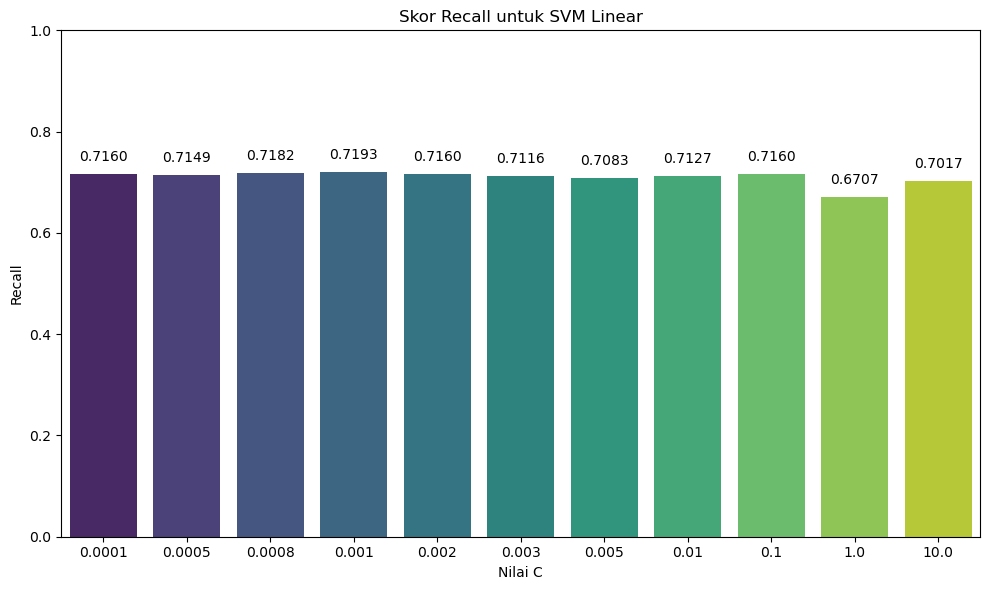

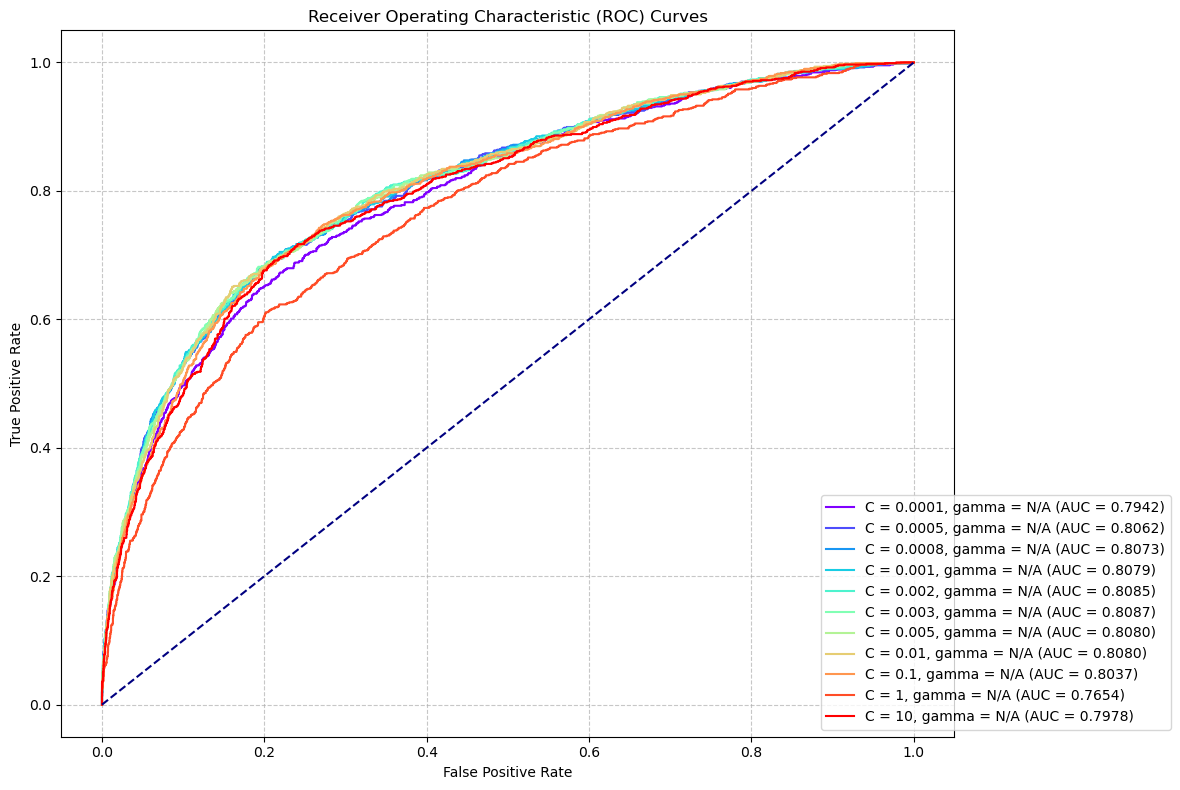

In [35]:
linear_visualizer = ModelEvaluationVisualizer(linear_tuner.results, kernel_name="linear")

linear_visualizer.plot_all()

# Visualize RBF Models

Saved confusion matrix plot: confusion_matrices\rbf_1.png
Saved confusion matrix plot: confusion_matrices\rbf_2.png
Saved confusion matrix plot: confusion_matrices\rbf_3.png
Saved confusion matrix plot: confusion_matrices\rbf_4.png
Saved confusion matrix plot: confusion_matrices\rbf_5.png
Saved confusion matrix plot: confusion_matrices\rbf_6.png
Saved confusion matrix plot: confusion_matrices\rbf_7.png
Saved confusion matrix plot: confusion_matrices\rbf_8.png
Saved confusion matrix plot: confusion_matrices\rbf_9.png
Saved confusion matrix plot: confusion_matrices\rbf_10.png
Saved confusion matrix plot: confusion_matrices\rbf_11.png
Saved confusion matrix plot: confusion_matrices\rbf_12.png
Saved confusion matrix plot: confusion_matrices\rbf_13.png
Saved confusion matrix plot: confusion_matrices\rbf_14.png
Saved confusion matrix plot: confusion_matrices\rbf_15.png
Saved confusion matrix plot: confusion_matrices\rbf_16.png
Saved confusion matrix plot: confusion_matrices\rbf_17.png
Saved 

C:\Users\stefa\AppData\Local\Temp\ipykernel_15652\3136896022.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gamma_values, y=recall_scores, palette="viridis")


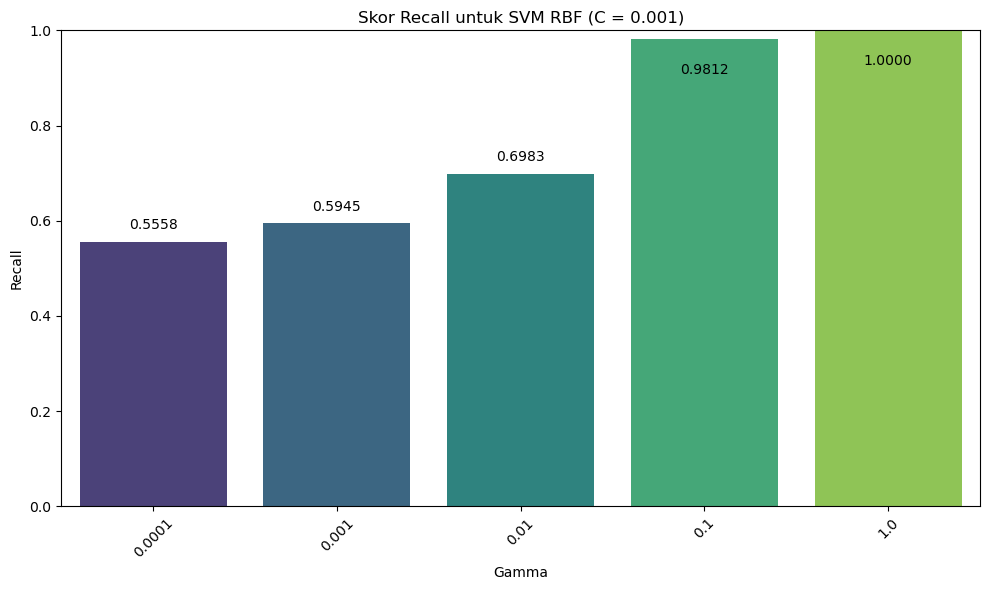

C:\Users\stefa\AppData\Local\Temp\ipykernel_15652\3136896022.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gamma_values, y=recall_scores, palette="viridis")


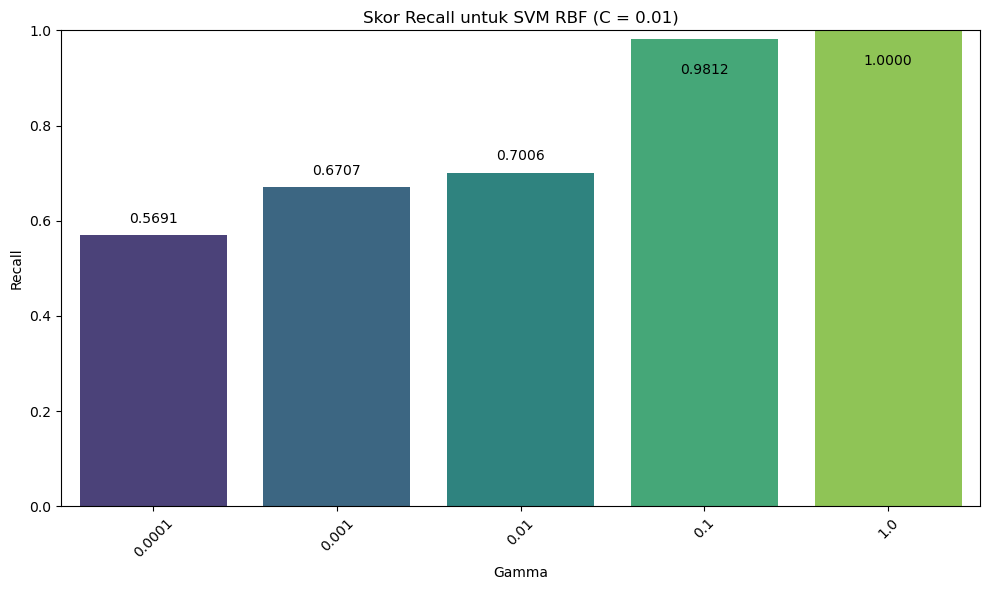

C:\Users\stefa\AppData\Local\Temp\ipykernel_15652\3136896022.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gamma_values, y=recall_scores, palette="viridis")


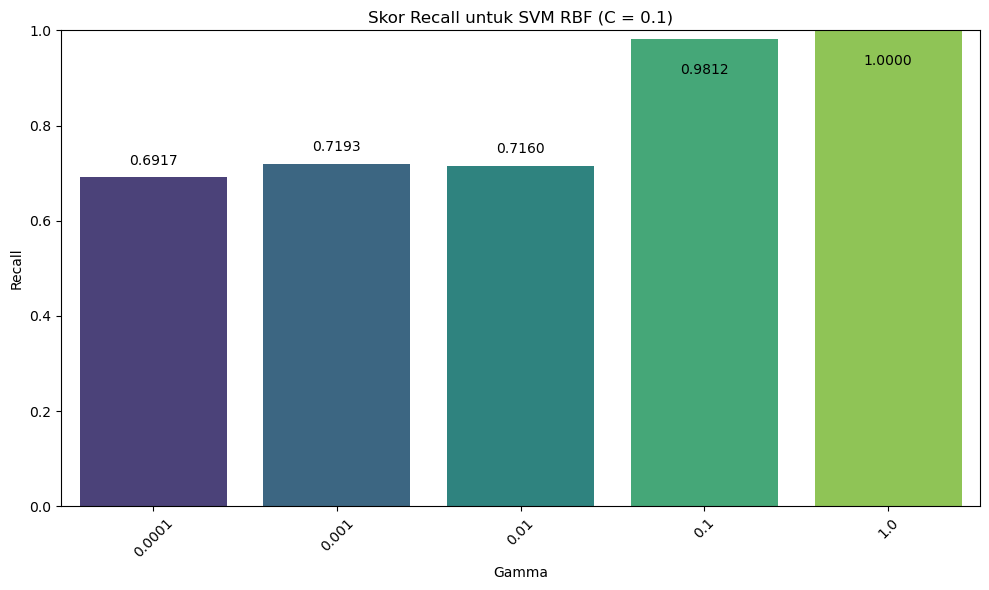

C:\Users\stefa\AppData\Local\Temp\ipykernel_15652\3136896022.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gamma_values, y=recall_scores, palette="viridis")


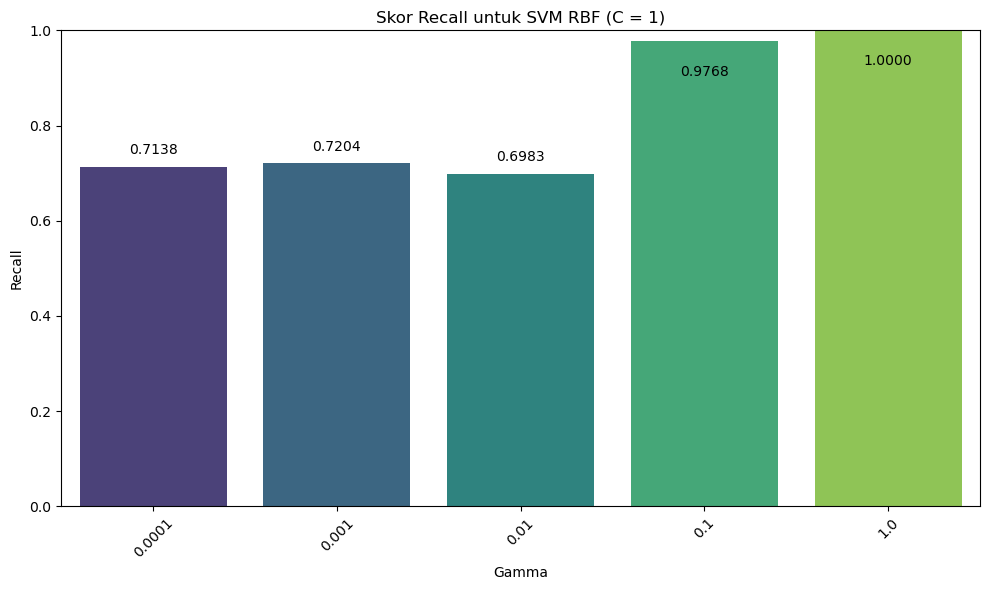

C:\Users\stefa\AppData\Local\Temp\ipykernel_15652\3136896022.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gamma_values, y=recall_scores, palette="viridis")


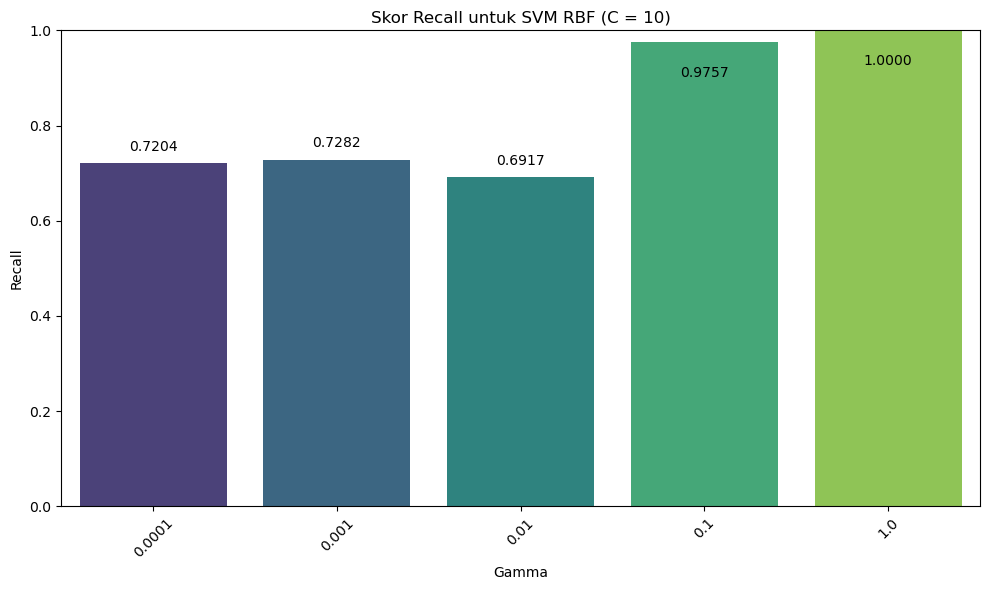

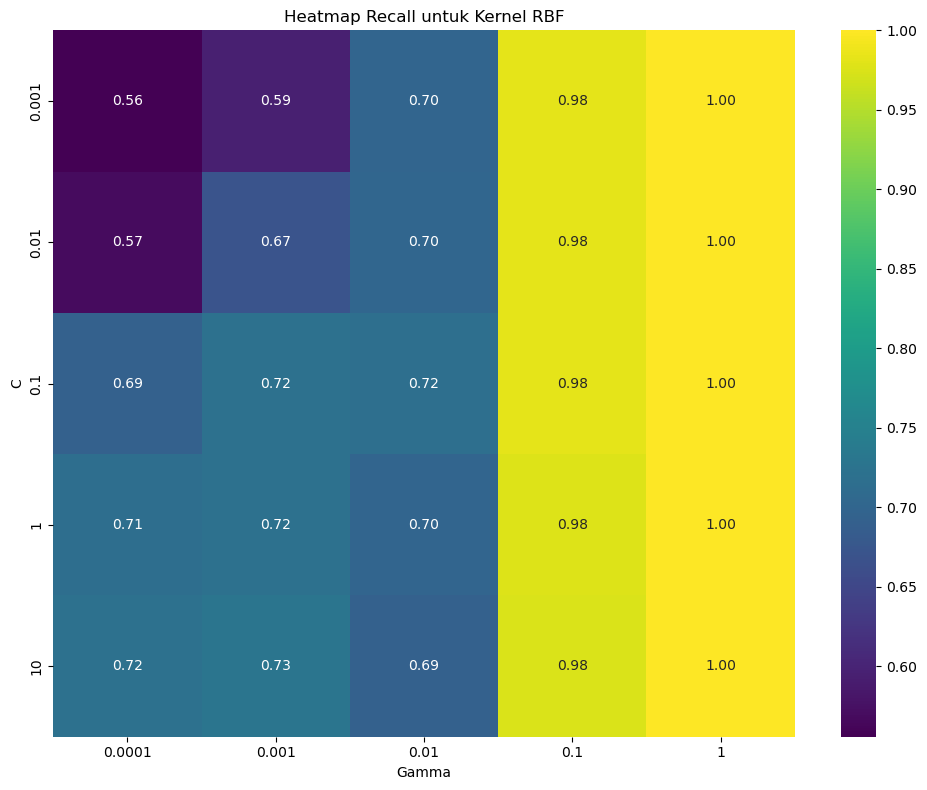

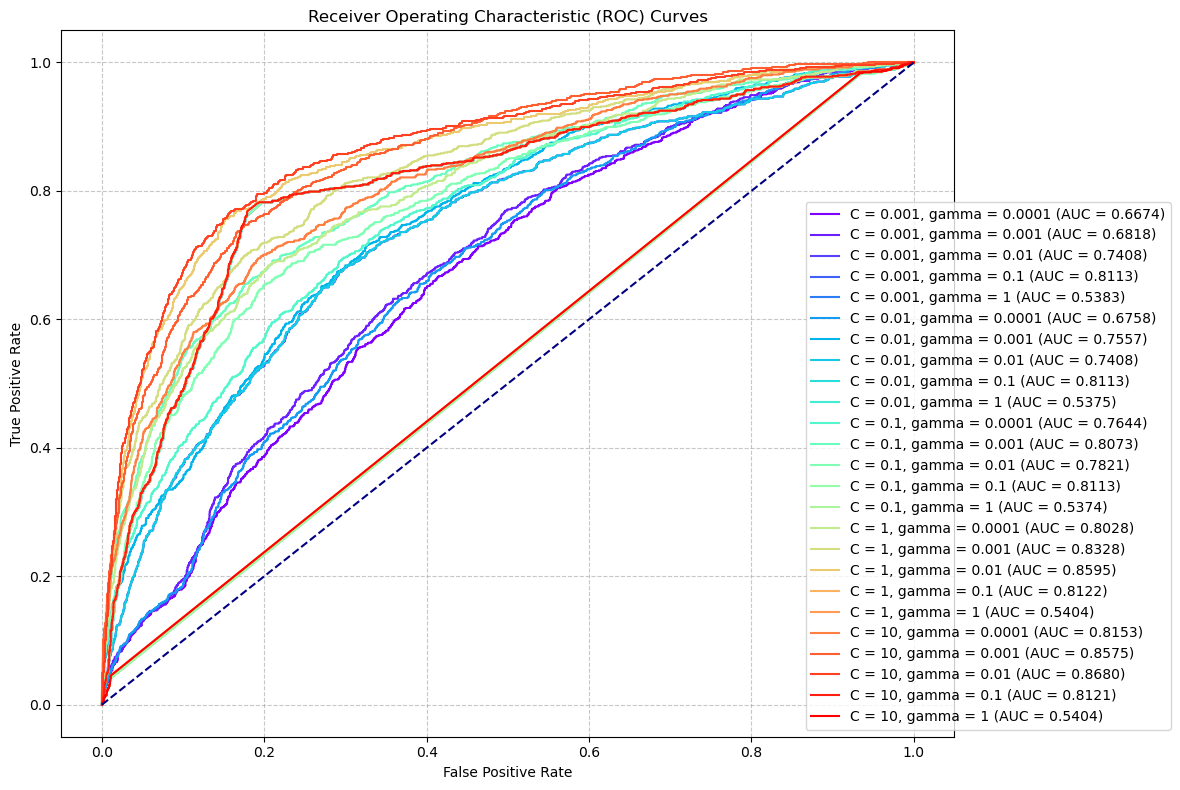

In [34]:
rbf_visualizer = ModelEvaluationVisualizer(rbf_tuner.results, kernel_name="rbf")

rbf_visualizer.plot_all()